# Requirement
1. Folder

> - 실행하는 폴더에 AFSNT, AFSNT_DLY가 들어 있어야 함
> - 전체 셀을 실행해야 함

2. Package

> - Python3.6
> - pandas, numpy, seaborn, catboost, scipy, sklearn, matplotlib

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# 라이브러리 임포트
!pip install catboost
# !pip install category_encoders
!pip install -U imbalanced-learn

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score,classification_report,\
confusion_matrix ,recall_score,precision_score,roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from scipy.stats import norm

from catboost import CatBoostClassifier
from catboost import Pool
np.random.seed(1)

# 데이터 파일 읽어들이기 
data = pd.read_csv('AFSNT.csv',encoding='ms949')
test = pd.read_csv('AFSNT_DLY.csv',encoding='ms949')


     |████████████████████████████████| 62.5MB 34.2MB/s 
     |████████████████████████████████| 174kB 6.5MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [0]:
# 결항인 경우 데이터 삭제
data = data[data['CNL'] != 'Y']
# 부정기편 제거
data = data[data['IRR'] == 'N']

# reset index
data = data.reset_index(drop = True)

test = test.replace('`','ARP1')
data = data.replace(['ARP1','ARP2','ARP3','ARP4','ARP5','ARP6','ARP7','ARP8','ARP9','ARP10','ARP11','ARP12','ARP13','ARP14','ARP15'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
test = test.replace(['ARP1','ARP2','ARP3','ARP4','ARP5','ARP6','ARP7','ARP8','ARP9','ARP10','ARP11','ARP12','ARP13','ARP14','ARP15'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

# 계획시간 시각 feature 생성
data['STT']=pd.to_datetime(data['STT'])
data['STT_hour']=data['STT'].dt.strftime('%H')
data['STT_min']=data['STT'].dt.strftime('%M')
data['STT_hour'] = data['STT_hour'].astype(int)
data['STT_min'] = data['STT_min'].astype(int)
# test도 수정
test['STT']=pd.to_datetime(test['STT'])
test['STT_hour']=test['STT'].dt.strftime('%H')
test['STT_min']=test['STT'].dt.strftime('%M')
test['STT_hour'] = test['STT_hour'].astype(int)
test['STT_min'] = test['STT_min'].astype(int)

data['pas'] = 0
data.loc[(data['ARP'] == 1),  'pas'] = 20324878.5
data.loc[(data['ARP'] == 2),  'pas'] = 7298338.5
data.loc[(data['ARP'] == 3),  'pas'] = 27460764
data.loc[(data['ARP'] == 4),  'pas'] = 1993016.5
data.loc[(data['ARP'] == 5),  'pas'] = 656660
data.loc[(data['ARP'] == 6),  'pas'] = 2215820
data.loc[(data['ARP'] == 7),  'pas'] = 174103.5
data.loc[(data['ARP'] == 8),  'pas'] = 1962567
data.loc[(data['ARP'] == 9),  'pas'] = 590219.5
data.loc[(data['ARP'] == 11),  'pas'] = 90990.5
data.loc[(data['ARP'] == 12),  'pas'] = 179974.5
data.loc[(data['ARP'] == 13),  'pas'] = 258776.5
data.loc[(data['ARP'] == 14),  'pas'] = 83642.5
data.loc[(data['ARP'] == 15),  'pas'] = 548237.5
# test
test['pas'] = 0
test.loc[(test['ARP'] == 1),  'pas'] = 20324878.5
test.loc[(test['ARP'] == 2),  'pas'] = 7298338.5
test.loc[(test['ARP'] == 3),  'pas'] = 27460764
test.loc[(test['ARP'] == 4),  'pas'] = 1993016.5
test.loc[(test['ARP'] == 5),  'pas'] = 656660
test.loc[(test['ARP'] == 6),  'pas'] = 2215820
test.loc[(test['ARP'] == 7),  'pas'] = 174103.5
test.loc[(test['ARP'] == 8),  'pas'] = 1962567
test.loc[(test['ARP'] == 9),  'pas'] = 590219.5
test.loc[(test['ARP'] == 10),  'pas'] = 0
test.loc[(test['ARP'] == 11),  'pas'] = 90990.5
test.loc[(test['ARP'] == 12),  'pas'] = 179974.5
test.loc[(test['ARP'] == 13),  'pas'] = 258776.5
test.loc[(test['ARP'] == 14),  'pas'] = 83642.5
test.loc[(test['ARP'] == 15),  'pas'] = 548237.5

data['num'] = 0
data.loc[(data['ARP'] == 1),  'num'] = 120780
data.loc[(data['ARP'] == 2),  'num'] = 47523.5
data.loc[(data['ARP'] == 3),  'num'] = 153832.5
data.loc[(data['ARP'] == 4),  'num'] = 12843.5
data.loc[(data['ARP'] == 5),  'num'] = 6005.5
data.loc[(data['ARP'] == 6),  'num'] = 13247.5
data.loc[(data['ARP'] == 7),  'num'] = 1147.5
data.loc[(data['ARP'] == 8),  'num'] = 13083
data.loc[(data['ARP'] == 9),  'num'] = 5008
data.loc[(data['ARP'] == 11),  'num'] = 1364.5
data.loc[(data['ARP'] == 12),  'num'] = 1885
data.loc[(data['ARP'] == 13),  'num'] = 1608.5
data.loc[(data['ARP'] == 14),  'num'] = 697.5
data.loc[(data['ARP'] == 15),  'num'] = 5294.5
# test
test['num'] = 0
test.loc[(test['ARP'] == 1),  'num'] = 120780
test.loc[(test['ARP'] == 2),  'num'] = 47523.5
test.loc[(test['ARP'] == 3),  'num'] = 153832.5
test.loc[(test['ARP'] == 4),  'num'] = 12843.5
test.loc[(test['ARP'] == 5),  'num'] = 6005.5
test.loc[(test['ARP'] == 6),  'num'] = 13247.5
test.loc[(test['ARP'] == 7),  'num'] = 1147.5
test.loc[(test['ARP'] == 8),  'num'] = 13083
test.loc[(test['ARP'] == 9),  'num'] = 5008
test.loc[(test['ARP'] == 10),  'num'] = 0
test.loc[(test['ARP'] == 11),  'num'] = 1364.5
test.loc[(test['ARP'] == 12),  'num'] = 1885
test.loc[(test['ARP'] == 13),  'num'] = 1608.5
test.loc[(test['ARP'] == 14),  'num'] = 697.5
test.loc[(test['ARP'] == 15),  'num'] = 5294.5

# route feature 추가
route = []
for i in range(len(test)):
  if test.iloc[i]['ARP']>test.iloc[i]['ODP']:
    l = test.iloc[i]['FLO']+str(test.iloc[i]['ODP'])+str(test.iloc[i]['ARP'])
  else:
    l = test.iloc[i]['FLO']+str(test.iloc[i]['ARP'])+str(test.iloc[i]['ODP'])
  route.append(l)
test['route'] = route

route = []
for i in range(len(data)):
  if data.iloc[i]['ARP']>data.iloc[i]['ODP']:
    l = data.iloc[i]['FLO']+str(data.iloc[i]['ODP'])+str(data.iloc[i]['ARP'])
  else:
    l = data.iloc[i]['FLO']+str(data.iloc[i]['ARP'])+str(data.iloc[i]['ODP'])
  route.append(l) 
data['route'] = route

# 테스트 데이터 훈련 데이터와 맞추기
test = test.drop(['DLY','DLY_RATE'], axis = 1)

# 분석에 사용하지 않는 피처 삭제
data = data.drop(['FLO','REG','DRR','CNL','CNR', 'ATT', 'STT', 'IRR'], axis=1)
test = test.drop(['FLO', 'STT'], axis = 1)

# data, target 지정
x = data.drop(['DLY'], axis = 1)
y = data['DLY']
y = y.replace(['N','Y'],[0,1])

# category_features 지정
cat_features = ['SDT_YY','SDT_MM','SDT_DD','SDT_DY','ARP','ODP','AOD','STT_hour','route','STT_min','FLT']

train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.016)
#모델 지정

ml_cb =  CatBoostClassifier(random_seed=1234,iterations=3000, depth=8, loss_function='CrossEntropy',eval_metric='AUC', task_type = 'GPU')

#모델 학습

ml_cb_output = ml_cb.fit(train_x,train_y,cat_features = cat_features, early_stopping_rounds=150,eval_set=(test_x,test_y),use_best_model=True)

pred = ml_cb_output.predict_proba(test_x)

results = ml_cb_output.predict(test_x)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y,results)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y,results)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y,results)
print('Recall: %f' % recall)

# ROC AUC
auc = roc_auc_score(test_y,pred[:,1])
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_y,results)
print(matrix)

fpr, tpr , thresholds = roc_curve(test_y, pred[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
print(fpr,tpr)
plt.plot(fpr , tpr,marker='.')
plt.show()

Learning rate set to 0.100083
0:	test: 0.6646310	best: 0.6646310 (0)	total: 1.2s	remaining: 59m 50s
1:	test: 0.6903984	best: 0.6903984 (1)	total: 2.65s	remaining: 1h 6m 15s
2:	test: 0.6903984	best: 0.6903984 (1)	total: 3.67s	remaining: 1h 1m 5s
3:	test: 0.7082360	best: 0.7082360 (3)	total: 5.57s	remaining: 1h 9m 35s
4:	test: 0.7811947	best: 0.7811947 (4)	total: 8.09s	remaining: 1h 20m 43s
5:	test: 0.7965796	best: 0.7965796 (5)	total: 9.67s	remaining: 1h 20m 26s
6:	test: 0.7966873	best: 0.7966873 (6)	total: 11.7s	remaining: 1h 23m 40s
7:	test: 0.8059189	best: 0.8059189 (7)	total: 13.8s	remaining: 1h 26m 8s
8:	test: 0.8084061	best: 0.8084061 (8)	total: 15.6s	remaining: 1h 26m 16s
9:	test: 0.8133280	best: 0.8133280 (9)	total: 18.2s	remaining: 1h 30m 39s
10:	test: 0.8181891	best: 0.8181891 (10)	total: 20.3s	remaining: 1h 32m 7s
11:	test: 0.8600632	best: 0.8600632 (11)	total: 22.5s	remaining: 1h 33m 17s
12:	test: 0.8806841	best: 0.8806841 (12)	total: 24.7s	remaining: 1h 34m 26s
13:	test: 0.

KeyboardInterrupt: ignored

Learning rate set to 0.100083
0:	learn: 0.7408046	test: 0.7628678	best: 0.7628678 (0)	total: 447ms	remaining: 22m 20s
1:	learn: 0.7492588	test: 0.7716834	best: 0.7716834 (1)	total: 822ms	remaining: 20m 31s
2:	learn: 0.7533545	test: 0.7772994	best: 0.7772994 (2)	total: 1.21s	remaining: 20m 8s
3:	learn: 0.8182667	test: 0.8813429	best: 0.8813429 (3)	total: 1.54s	remaining: 19m 14s
4:	learn: 0.8159228	test: 0.8775684	best: 0.8813429 (3)	total: 1.9s	remaining: 18m 58s
5:	learn: 0.8154082	test: 0.8755725	best: 0.8813429 (3)	total: 2.21s	remaining: 18m 24s
6:	learn: 0.8153034	test: 0.8745021	best: 0.8813429 (3)	total: 2.55s	remaining: 18m 12s
7:	learn: 0.8152016	test: 0.8735800	best: 0.8813429 (3)	total: 2.95s	remaining: 18m 22s
8:	learn: 0.8146249	test: 0.8723892	best: 0.8813429 (3)	total: 3.26s	remaining: 18m 2s
9:	learn: 0.8155746	test: 0.8734416	best: 0.8813429 (3)	total: 3.57s	remaining: 17m 47s
10:	learn: 0.8457527	test: 0.8981427	best: 0.8981427 (10)	total: 3.96s	remaining: 17m 54s
11:

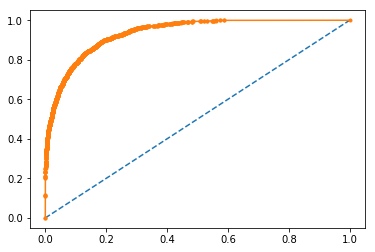

In [0]:
ml_cb =  CatBoostClassifier(random_seed=1234,iterations=3000, depth=8, loss_function='CrossEntropy',eval_metric='AUC', task_type = 'GPU')

#모델 학습

ml_cb_output = ml_cb.fit(train_x,train_y,cat_features = cat_features, early_stopping_rounds=150,eval_set=(test_x,test_y),use_best_model=True)

pred = ml_cb_output.predict_proba(test_x)

results = ml_cb_output.predict(test_x)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y,results)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y,results)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y,results)
print('Recall: %f' % recall)

# ROC AUC
auc = roc_auc_score(test_y,pred[:,1])
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_y,results)
print(matrix)

fpr, tpr , thresholds = roc_curve(test_y, pred[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
print(fpr,tpr)
plt.plot(fpr , tpr,marker='.')
plt.show()

In [0]:
pred = ml_cb_output.predict_proba(test)
result = ml_cb_output.predict(test)

In [0]:
test['DLY'] = result
test['DLY'] = test['DLY'].replace([0,1], ['N', 'Y'])
test['DLY_RATE'] = pred[:,1]

In [0]:
test.to_csv('submit.csv', index=False, encoding='euc-kr')
data.to_csv('data.csv', index=False, encoding='euc-kr')